In [1]:
from requests import Request, Session
from requests.exceptions import ConnectionError, Timeout, TooManyRedirects
import json

url = 'https://pro-api.coinmarketcap.com/v1/cryptocurrency/listings/latest'
parameters = {
  'start':'1',
  'limit':'15',
  'convert':'USD'
}
headers = {
  'Accepts': 'application/json',
  'X-CMC_PRO_API_KEY': 'aa22da52-0c5f-482b-8272-a62c9277ca97',
}

session = Session()
session.headers.update(headers)

try:
  response = session.get(url, params=parameters)
  data = json.loads(response.text)
  print(data)
except (ConnectionError, Timeout, TooManyRedirects) as e:
  print(e)

{'status': {'timestamp': '2022-06-20T09:04:25.069Z', 'error_code': 0, 'error_message': None, 'elapsed': 47, 'credit_count': 1, 'notice': None, 'total_count': 9907}, 'data': [{'id': 1, 'name': 'Bitcoin', 'symbol': 'BTC', 'slug': 'bitcoin', 'num_market_pairs': 9542, 'date_added': '2013-04-28T00:00:00.000Z', 'tags': ['mineable', 'pow', 'sha-256', 'store-of-value', 'state-channel', 'coinbase-ventures-portfolio', 'three-arrows-capital-portfolio', 'polychain-capital-portfolio', 'binance-labs-portfolio', 'blockchain-capital-portfolio', 'boostvc-portfolio', 'cms-holdings-portfolio', 'dcg-portfolio', 'dragonfly-capital-portfolio', 'electric-capital-portfolio', 'fabric-ventures-portfolio', 'framework-ventures-portfolio', 'galaxy-digital-portfolio', 'huobi-capital-portfolio', 'alameda-research-portfolio', 'a16z-portfolio', '1confirmation-portfolio', 'winklevoss-capital-portfolio', 'usv-portfolio', 'placeholder-ventures-portfolio', 'pantera-capital-portfolio', 'multicoin-capital-portfolio', 'parad

In [2]:
type(data)

dict

In [3]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [4]:
df = pd.json_normalize(data['data'])
df['timestamp'] = pd.to_datetime('now')
df

C:\Anaconda\lib\site-packages\pandas\core\arrays\datetimes.py:2199: FutureWarning: The parsing of 'now' in pd.to_datetime without `utc=True` is deprecated. In a future version, this will match Timestamp('now') and Timestamp.now()
  result, tz_parsed = tslib.array_to_datetime(


,id,name,symbol,slug,num_market_pairs,date_added,tags,max_supply,circulating_supply,total_supply,platform,cmc_rank,self_reported_circulating_supply,self_reported_market_cap,tvl_ratio,last_updated,quote.USD.price,quote.USD.volume_24h,quote.USD.volume_change_24h,quote.USD.percent_change_1h,quote.USD.percent_change_24h,quote.USD.percent_change_7d,quote.USD.percent_change_30d,quote.USD.percent_change_60d,quote.USD.percent_change_90d,quote.USD.market_cap,quote.USD.market_cap_dominance,quote.USD.fully_diluted_market_cap,quote.USD.tvl,quote.USD.last_updated,platform.id,platform.name,platform.symbol,platform.slug,platform.token_address,timestamp
0,1,Bitcoin,BTC,bitcoin,9542,2013-04-28T00:00:00.000Z,"[mineable, pow, sha-256, store-of-value, state...",2.100000e+07,1.907217e+07,1.907217e+07,NaN,1,NaN,NaN,None,2022-06-20T09:04:00.000Z,20510.433201,3.643451e+10,-9.3130,2.375335,10.210150,-15.180226,-30.120043,-51.053214,-51.775038,3.911784e+11,43.5387,4.307191e+11,None,2022-06-20T09:04:00.000Z,NaN,NaN,NaN,NaN,NaN,2022-06-20 09:04:28.207920
1,1027,Ethereum,ETH,ethereum,5755,2015-08-07T00:00:00.000Z,"[mineable, pow, smart-contracts, ethereum-ecos...",NaN,1.212394e+08,1.212394e+08,NaN,2,NaN,NaN,None,2022-06-20T09:03:00.000Z,1119.949104,2.245604e+10,5.2174,3.968341,15.884927,-7.988485,-43.338375,-63.880860,-62.836574,1.357820e+11,15.1096,1.357820e+11,None,2022-06-20T09:03:00.000Z,NaN,NaN,NaN,NaN,NaN,2022-06-20 09:04:28.207920
2,825,Tether,USDT,tether,34857,2015-02-25T00:00:00.000Z,"[payments, stablecoin, asset-backed-stablecoin...",NaN,6.792430e+10,7.971062e+10,NaN,3,NaN,NaN,None,2022-06-20T09:03:00.000Z,0.998924,5.796744e+10,-4.0727,0.006398,0.026914,0.056966,0.014766,-0.127744,-0.147922,6.785124e+10,7.5519,7.962489e+10,None,2022-06-20T09:03:00.000Z,1027.0,Ethereum,ETH,ethereum,0xdac17f958d2ee523a2206206994597c13d831ec7,2022-06-20 09:04:28.207920
3,3408,USD Coin,USDC,usd-coin,4480,2018-10-08T00:00:00.000Z,"[medium-of-exchange, stablecoin, asset-backed-...",NaN,5.592066e+10,5.592066e+10,NaN,4,NaN,NaN,None,2022-06-20T09:03:00.000Z,1.000378,5.784773e+09,-16.9573,0.008361,0.006759,0.038689,0.026574,0.042970,0.059672,5.594177e+10,6.2251,5.594177e+10,None,2022-06-20T09:03:00.000Z,1027.0,Ethereum,ETH,ethereum,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,2022-06-20 09:04:28.207920
4,1839,BNB,BNB,bnb,963,2017-07-25T00:00:00.000Z,"[marketplace, centralized-exchange, payments, ...",1.651168e+08,1.632770e+08,1.632770e+08,NaN,5,NaN,NaN,None,2022-06-20T09:03:00.000Z,211.212763,1.342280e+09,-7.6492,2.142722,7.957133,-4.870563,-30.994059,-49.823883,-47.979023,3.448618e+10,3.8384,3.487477e+10,None,2022-06-20T09:03:00.000Z,NaN,NaN,NaN,NaN,NaN,2022-06-20 09:04:28.207920
5,4687,Binance USD,BUSD,binance-usd,3860,2019-09-20T00:00:00.000Z,"[stablecoin, asset-backed-stablecoin, binance-...",NaN,1.718413e+10,1.718413e+10,NaN,6,NaN,NaN,None,2022-06-20T09:04:00.000Z,0.999041,5.187460e+09,-15.1674,-0.060488,-0.282170,-0.166485,-0.026615,-0.172228,-0.150509,1.716766e+10,1.9104,1.716766e+10,None,2022-06-20T09:04:00.000Z,1839.0,BNB,BNB,bnb,BUSD-BD1,2022-06-20 09:04:28.207920
6,2010,Cardano,ADA,cardano,459,2017-10-01T00:00:00.000Z,"[mineable, dpos, pos, platform, research, smar...",4.500000e+10,3.393405e+10,3.427770e+10,NaN,7,NaN,NaN,None,2022-06-20T09:03:00.000Z,0.478013,1.027063e+09,-11.0571,2.310227,5.711582,7.882875,-9.382216,-49.702265,-49.243238,1.622091e+10,1.8050,2.151057e+10,None,2022-06-20T09:03:00.000Z,NaN,NaN,NaN,NaN,NaN,2022-06-20 09:04:28.207920
7,52,XRP,XRP,xrp,740,2013-08-04T00:00:00.000Z,"[medium-of-exchange, enterprise-solutions, bin...",1.000000e+11,4.834310e+10,9.998954e+10,NaN,8,NaN,NaN,None,2022-06-20T09:04:00.000Z,0.320565,1.256469e+09,-0.0762,1.000247,4.481482,3.900492,-22.072198,-57.259637,-62.168187,1.549710e+10,1.7249,3.205649e+10,None,2022-06-20T09:04:00.000Z,NaN,NaN,NaN,NaN,NaN,2022-06-20 09:04:28.207920
8,5426,Solana,SOL,solana,334,2020-04-10T00:00:00.000Z,"[pos, platform, solana-ecosystem, cms-holdings...",NaN,3.425098e+08,5.116169e+08,NaN,9,NaN

In [10]:
def api_runner():
    global df
    url = 'https://pro-api.coinmarketcap.com/v1/cryptocurrency/listings/latest' 
    
    parameters = {
      'start':'1',
      'limit':'15',
      'convert':'USD'
    }
    headers = {
      'Accepts': 'application/json',
      'X-CMC_PRO_API_KEY': 'aa22da52-0c5f-482b-8272-a62c9277ca97',
    }

    session = Session()
    session.headers.update(headers)

    try:
      response = session.get(url, params=parameters)
      data = json.loads(response.text)
      
    except (ConnectionError, Timeout, TooManyRedirects) as e:
      print(e)
    
    
    df2 = pd.json_normalize(data['data'])
    df2['timestamp'] = pd.to_datetime('now')
    df = df.append(df2)
    
    if not os.path.isfile(r'C:\Users\ΜΑΝΟΣ Ψ\Documents\Σημαντικα Εγγραφα\Portofolio Projects\Portofolio Project.1\Python Portfolio Project\Automating API Pull Python\API.csv'):
        df.to_csv(r'C:\Users\ΜΑΝΟΣ Ψ\Documents\Σημαντικα Εγγραφα\Portofolio Projects\Portofolio Project.1\Python Portfolio Project\Automating API Pull Python\API.csv', header='column_names')
    else:
        df.to_csv(r'C:\Users\ΜΑΝΟΣ Ψ\Documents\Σημαντικα Εγγραφα\Portofolio Projects\Portofolio Project.1\Python Portfolio Project\Automating API Pull Python\API.csv', mode='a', header=False)


In [11]:
import os 
from time import time
from time import sleep

for i in range(333):
    api_runner()
    print('API Runner completed')
    sleep(60) 
exit()

C:\Anaconda\lib\site-packages\pandas\core\arrays\datetimes.py:2199: FutureWarning: The parsing of 'now' in pd.to_datetime without `utc=True` is deprecated. In a future version, this will match Timestamp('now') and Timestamp.now()
  result, tz_parsed = tslib.array_to_datetime(
C:\Users\CCC9~1\AppData\Local\Temp/ipykernel_7956/2341534435.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df2)


API Runner completed


C:\Anaconda\lib\site-packages\pandas\core\arrays\datetimes.py:2199: FutureWarning: The parsing of 'now' in pd.to_datetime without `utc=True` is deprecated. In a future version, this will match Timestamp('now') and Timestamp.now()
  result, tz_parsed = tslib.array_to_datetime(
C:\Users\CCC9~1\AppData\Local\Temp/ipykernel_7956/2341534435.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df2)


API Runner completed


KeyboardInterrupt: 

In [12]:
df

,id,name,symbol,slug,num_market_pairs,date_added,tags,max_supply,circulating_supply,total_supply,platform,cmc_rank,self_reported_circulating_supply,self_reported_market_cap,tvl_ratio,last_updated,quote.USD.price,quote.USD.volume_24h,quote.USD.volume_change_24h,quote.USD.percent_change_1h,quote.USD.percent_change_24h,quote.USD.percent_change_7d,quote.USD.percent_change_30d,quote.USD.percent_change_60d,quote.USD.percent_change_90d,quote.USD.market_cap,quote.USD.market_cap_dominance,quote.USD.fully_diluted_market_cap,quote.USD.tvl,quote.USD.last_updated,platform.id,platform.name,platform.symbol,platform.slug,platform.token_address,timestamp
0,1,Bitcoin,BTC,bitcoin,9542,2013-04-28T00:00:00.000Z,"[mineable, pow, sha-256, store-of-value, state...",2.100000e+07,1.907217e+07,1.907217e+07,NaN,1,NaN,NaN,None,2022-06-20T09:04:00.000Z,20510.433201,3.643451e+10,-9.3130,2.375335,10.210150,-15.180226,-30.120043,-51.053214,-51.775038,3.911784e+11,43.5387,4.307191e+11,None,2022-06-20T09:04:00.000Z,NaN,NaN,NaN,NaN,NaN,2022-06-20 09:04:28.207920
1,1027,Ethereum,ETH,ethereum,5755,2015-08-07T00:00:00.000Z,"[mineable, pow, smart-contracts, ethereum-ecos...",NaN,1.212394e+08,1.212394e+08,NaN,2,NaN,NaN,None,2022-06-20T09:03:00.000Z,1119.949104,2.245604e+10,5.2174,3.968341,15.884927,-7.988485,-43.338375,-63.880860,-62.836574,1.357820e+11,15.1096,1.357820e+11,None,2022-06-20T09:03:00.000Z,NaN,NaN,NaN,NaN,NaN,2022-06-20 09:04:28.207920
2,825,Tether,USDT,tether,34857,2015-02-25T00:00:00.000Z,"[payments, stablecoin, asset-backed-stablecoin...",NaN,6.792430e+10,7.971062e+10,NaN,3,NaN,NaN,None,2022-06-20T09:03:00.000Z,0.998924,5.796744e+10,-4.0727,0.006398,0.026914,0.056966,0.014766,-0.127744,-0.147922,6.785124e+10,7.5519,7.962489e+10,None,2022-06-20T09:03:00.000Z,1027.0,Ethereum,ETH,ethereum,0xdac17f958d2ee523a2206206994597c13d831ec7,2022-06-20 09:04:28.207920
3,3408,USD Coin,USDC,usd-coin,4480,2018-10-08T00:00:00.000Z,"[medium-of-exchange, stablecoin, asset-backed-...",NaN,5.592066e+10,5.592066e+10,NaN,4,NaN,NaN,None,2022-06-20T09:03:00.000Z,1.000378,5.784773e+09,-16.9573,0.008361,0.006759,0.038689,0.026574,0.042970,0.059672,5.594177e+10,6.2251,5.594177e+10,None,2022-06-20T09:03:00.000Z,1027.0,Ethereum,ETH,ethereum,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,2022-06-20 09:04:28.207920
4,1839,BNB,BNB,bnb,963,2017-07-25T00:00:00.000Z,"[marketplace, centralized-exchange, payments, ...",1.651168e+08,1.632770e+08,1.632770e+08,NaN,5,NaN,NaN,None,2022-06-20T09:03:00.000Z,211.212763,1.342280e+09,-7.6492,2.142722,7.957133,-4.870563,-30.994059,-49.823883,-47.979023,3.448618e+10,3.8384,3.487477e+10,None,2022-06-20T09:03:00.000Z,NaN,NaN,NaN,NaN,NaN,2022-06-20 09:04:28.207920
5,4687,Binance USD,BUSD,binance-usd,3860,2019-09-20T00:00:00.000Z,"[stablecoin, asset-backed-stablecoin, binance-...",NaN,1.718413e+10,1.718413e+10,NaN,6,NaN,NaN,None,2022-06-20T09:04:00.000Z,0.999041,5.187460e+09,-15.1674,-0.060488,-0.282170,-0.166485,-0.026615,-0.172228,-0.150509,1.716766e+10,1.9104,1.716766e+10,None,2022-06-20T09:04:00.000Z,1839.0,BNB,BNB,bnb,BUSD-BD1,2022-06-20 09:04:28.207920
6,2010,Cardano,ADA,cardano,459,2017-10-01T00:00:00.000Z,"[mineable, dpos, pos, platform, research, smar...",4.500000e+10,3.393405e+10,3.427770e+10,NaN,7,NaN,NaN,None,2022-06-20T09:03:00.000Z,0.478013,1.027063e+09,-11.0571,2.310227,5.711582,7.882875,-9.382216,-49.702265,-49.243238,1.622091e+10,1.8050,2.151057e+10,None,2022-06-20T09:03:00.000Z,NaN,NaN,NaN,NaN,NaN,2022-06-20 09:04:28.207920
7,52,XRP,XRP,xrp,740,2013-08-04T00:00:00.000Z,"[medium-of-exchange, enterprise-solutions, bin...",1.000000e+11,4.834310e+10,9.998954e+10,NaN,8,NaN,NaN,None,2022-06-20T09:04:00.000Z,0.320565,1.256469e+09,-0.0762,1.000247,4.481482,3.900492,-22.072198,-57.259637,-62.168187,1.549710e+10,1.7249,3.205649e+10,None,2022-06-20T09:04:00.000Z,NaN,NaN,NaN,NaN,NaN,2022-06-20 09:04:28.207920
8,5426,Solana,SOL,solana,334,2020-04-10T00:00:00.000Z,"[pos, platform, solana-ecosystem, cms-holdings...",NaN,3.425098e+08,5.116169e+08,NaN,9,NaN

In [13]:
pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [14]:
df

,id,name,symbol,slug,num_market_pairs,date_added,tags,max_supply,circulating_supply,total_supply,platform,cmc_rank,self_reported_circulating_supply,self_reported_market_cap,tvl_ratio,last_updated,quote.USD.price,quote.USD.volume_24h,quote.USD.volume_change_24h,quote.USD.percent_change_1h,quote.USD.percent_change_24h,quote.USD.percent_change_7d,quote.USD.percent_change_30d,quote.USD.percent_change_60d,quote.USD.percent_change_90d,quote.USD.market_cap,quote.USD.market_cap_dominance,quote.USD.fully_diluted_market_cap,quote.USD.tvl,quote.USD.last_updated,platform.id,platform.name,platform.symbol,platform.slug,platform.token_address,timestamp
0,1,Bitcoin,BTC,bitcoin,9542,2013-04-28T00:00:00.000Z,"[mineable, pow, sha-256, store-of-value, state...",21000000.00000,19072168.00000,19072168.00000,NaN,1,NaN,NaN,None,2022-06-20T09:04:00.000Z,20510.43320,36434512458.59784,-9.31300,2.37533,10.21015,-15.18023,-30.12004,-51.05321,-51.77504,391178427771.02325,43.53870,430719097230.65997,None,2022-06-20T09:04:00.000Z,NaN,NaN,NaN,NaN,NaN,2022-06-20 09:04:28.207920
1,1027,Ethereum,ETH,ethereum,5755,2015-08-07T00:00:00.000Z,"[mineable, pow, smart-contracts, ethereum-ecos...",NaN,121239424.93650,121239424.93650,NaN,2,NaN,NaN,None,2022-06-20T09:03:00.000Z,1119.94910,22456043514.43798,5.21740,3.96834,15.88493,-7.98848,-43.33837,-63.88086,-62.83657,135781985380.90810,15.10960,135781985380.91000,None,2022-06-20T09:03:00.000Z,NaN,NaN,NaN,NaN,NaN,2022-06-20 09:04:28.207920
2,825,Tether,USDT,tether,34857,2015-02-25T00:00:00.000Z,"[payments, stablecoin, asset-backed-stablecoin...",NaN,67924299701.40053,79710622658.12675,NaN,3,NaN,NaN,None,2022-06-20T09:03:00.000Z,0.99892,57967435101.73955,-4.07270,0.00640,0.02691,0.05697,0.01477,-0.12774,-0.14792,67851240345.01000,7.55190,79624885936.30000,None,2022-06-20T09:03:00.000Z,1027.00000,Ethereum,ETH,ethereum,0xdac17f958d2ee523a2206206994597c13d831ec7,2022-06-20 09:04:28.207920
3,3408,USD Coin,USDC,usd-coin,4480,2018-10-08T00:00:00.000Z,"[medium-of-exchange, stablecoin, asset-backed-...",NaN,55920659530.93723,55920659530.93723,NaN,4,NaN,NaN,None,2022-06-20T09:03:00.000Z,1.00038,5784772663.50996,-16.95730,0.00836,0.00676,0.03869,0.02657,0.04297,0.05967,55941773605.39014,6.22510,55941773605.39000,None,2022-06-20T09:03:00.000Z,1027.00000,Ethereum,ETH,ethereum,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,2022-06-20 09:04:28.207920
4,1839,BNB,BNB,bnb,963,2017-07-25T00:00:00.000Z,"[marketplace, centralized-exchange, payments, ...",165116760.00000,163276974.63000,163276974.63000,NaN,5,NaN,NaN,None,2022-06-20T09:03:00.000Z,211.21276,1342279678.78768,-7.64920,2.14272,7.95713,-4.87056,-30.99406,-49.82388,-47.97902,34486180903.20609,3.83840,34874767054.05000,None,2022-06-20T09:03:00.000Z,NaN,NaN,NaN,NaN,NaN,2022-06-20 09:04:28.207920
5,4687,Binance USD,BUSD,binance-usd,3860,2019-09-20T00:00:00.000Z,"[stablecoin, asset-backed-stablecoin, binance-...",NaN,17184126306.57925,17184126306.57925,NaN,6,NaN,NaN,None,2022-06-20T09:04:00.000Z,0.99904,5187460492.43629,-15.16740,-0.06049,-0.28217,-0.16648,-0.02661,-0.17223,-0.15051,17167655247.15961,1.91040,17167655247.16000,None,2022-06-20T09:04:00.000Z,1839.00000,BNB,BNB,bnb,BUSD-BD1,2022-06-20 09:04:28.207920
6,2010,Cardano,ADA,cardano,459,2017-10-01T00:00:00.000Z,"[mineable, dpos, pos, platform, research, smar...",45000000000.00000,33934048405.59300,34277702081.60500,NaN,7,NaN,NaN,None,2022-06-20T09:03:00.000Z,0.47801,1027063402.19583,-11.05710,2.31023,5.71158,7.88287,-9.38222,-49.70226,-49.24324,16220907584.49225,1.80500,21510573468.21000,None,2022-06-20T09:03:00.000Z,NaN,NaN,NaN,NaN,NaN,2022-06-20 09:04:28.207920
7,52,XRP,XRP,xrp,740,2013-08-04T00:00:00.000Z,"[medium-of-exchange, enterprise-solutions, bin...",100000000000.00000,48343101197.00000,99989535142.00000,NaN,8,NaN,NaN,None,2022-06-20T09:04:00.000Z,0.32056,1256469323.26811,-0.07620,1.00025,4.48148,3.90049,-22.07220,-57.25964,-62.16819,15497102518.58300,1.72490,32056492311.97000,None,2022-06-20T09:04:00.000Z,NaN,NaN,NaN,NaN,NaN

In [17]:
df3 = df.groupby('name', sort=False)[['quote.USD.percent_change_1h','quote.USD.percent_change_24h','quote.USD.percent_change_7d','quote.USD.percent_change_90d']].mean()
df3

,quote.USD.percent_change_1h,quote.USD.percent_change_24h,quote.USD.percent_change_7d,quote.USD.percent_change_90d
name,,,,
Bitcoin,1.51727,9.47794,-15.59548,-51.64376
Ethereum,2.45331,14.73462,-9.27793,-62.71445
Tether,0.00478,0.01793,0.05089,-0.15631
USD Coin,0.00425,-0.04052,-0.00250,0.05467
BNB,1.10033,6.89255,-6.28828,-47.90365
Binance USD,-0.16621,-0.21337,-0.11144,-0.12521
Cardano,1.85235,5.33797,6.96286,-49.03625
XRP,0.72977,4.23517,2.50726,-62.08952
Solana,2.80504,12.66301,25.13546,-62.94914


In [18]:
df4 = df3.stack()
df4

name                                         
Bitcoin          quote.USD.percent_change_1h      1.51727
                 quote.USD.percent_change_24h     9.47794
                 quote.USD.percent_change_7d    -15.59548
                 quote.USD.percent_change_90d   -51.64376
Ethereum         quote.USD.percent_change_1h      2.45331
                 quote.USD.percent_change_24h    14.73462
                 quote.USD.percent_change_7d     -9.27793
                 quote.USD.percent_change_90d   -62.71445
Tether           quote.USD.percent_change_1h      0.00478
                 quote.USD.percent_change_24h     0.01793
                 quote.USD.percent_change_7d      0.05089
                 quote.USD.percent_change_90d    -0.15631
USD Coin         quote.USD.percent_change_1h      0.00425
                 quote.USD.percent_change_24h    -0.04052
                 quote.USD.percent_change_7d     -0.00250
                 quote.USD.percent_change_90d     0.05467
BNB              quote.USD

In [19]:
type(df4)

pandas.core.series.Series

In [20]:
df5 = df4.to_frame(name='values')
df5

values
name                                                  
Bitcoin         quote.USD.percent_change_1h    1.51727
                quote.USD.percent_change_24h   9.47794
                quote.USD.percent_change_7d  -15.59548
                quote.USD.percent_change_90d -51.64376
Ethereum        quote.USD.percent_change_1h    2.45331
                quote.USD.percent_change_24h  14.73462
                quote.USD.percent_change_7d   -9.27793
                quote.USD.percent_change_90d -62.71445
Tether          quote.USD.percent_change_1h    0.00478
                quote.USD.percent_change_24h   0.01793
                quote.USD.percent_change_7d    0.05089
                quote.USD.percent_change_90d  -0.15631
USD Coin        quote.USD.percent_change_1h    0.00425
                quote.USD.percent_change_24h  -0.04052
                quote.USD.percent_change_7d   -0.00250
                quote.USD.percent_change_90d   0.05467
BNB             quote.USD.percent_change_1h    1.10033
                quote.USD.percent_change_24h   6.89255
                quote.USD.percent_change_7d   -6.28828
                quote.USD.percent_change_90d -47.90365
Binance USD     quote.USD.percent_change_1h   -0.16621
                quote.USD.percent_change_24h  -0.21337
                quote.USD.percent_change_7d   -0.11144
                quote.USD.percent_change_90d  -0.12521
Cardano         quote.USD.percent_change_1h    1.85235
                quote.USD.percent_change_24h   5.33797
                quote.USD.percent_change_7d    6.96286
                quote.USD.percent_change_90d -49.03625
XRP             quote.USD.percent_change_1h    0.72977
                quote.USD.percent_change_24h   4.23517
                quote.USD.percent_change_7d    2.50726
                quote.USD.percent_change_90d -62.08952
Solana          quote.USD.percent_change_1h    2.80504
                quote.USD.percent_change_24h  12.66301
                quote.USD.percent_change_7d   25.13546
                quote.USD.percent_change_90d -62.94914
Dogecoin        quote.USD.percent_change_1h    1.40941
                quote.USD.percent_change_24h   3.97888
                quote.USD.percent_change_7d    8.41420
                quote.USD.percent_change_90d -51.91060
Polkadot        quote.USD.percent_change_1h    1.09020
                quote.USD.percent_change_24h   6.62025
                quote.USD.percent_change_7d   12.93324
                quote.USD.percent_change_90d -62.18589
Dai             quote.USD.percent_change_1h    0.07431
                quote.USD.percent_change_24h   0.00535
                quote.USD.percent_change_7d    0.06339
                quote.USD.percent_change_90d   0.15755
TRON            quote.USD.percent_change_1h    1.07385
                quote.USD.percent_change_24h   0.03759
                quote.USD.percent_change_7d   -5.51227
                quote.USD.percent_change_90d  -3.54388
Wrapped Bitcoin quote.USD.percent_change_1h    1.81971
                quote.USD.percent_change_24h   9.97654
                quote.USD.percent_change_7d  -15.50422
                quote.USD.percent_change_90d -51.63347
UNUS SED LEO    quote.USD.percent_change_1h    0.27345
                quote.USD.percent_change_24h   7.63231
                quote.USD.percent_change_7d   -1.45436
                quote.USD.percent_change_90d -11.17776

In [21]:
df5.count()

values    60
dtype: int64

In [24]:
index = pd.Index(range(60))

df6 = df5.reset_index()

In [25]:
df6

,name,level_1,values
0,Bitcoin,quote.USD.percent_change_1h,1.51727
1,Bitcoin,quote.USD.percent_change_24h,9.47794
2,Bitcoin,quote.USD.percent_change_7d,-15.59548
3,Bitcoin,quote.USD.percent_change_90d,-51.64376
4,Ethereum,quote.USD.percent_change_1h,2.45331
5,Ethereum,quote.USD.percent_change_24h,14.73462
6,Ethereum,quote.USD.percent_change_7d,-9.27793
7,Ethereum,quote.USD.percent_change_90d,-62.71445
8,Tether,quote.USD.percent_change_1h,0.00478
9,Tether,quote.USD.percent_change_24h,0.01793


In [27]:
df7 = df6.rename(columns={'level_1': 'percent_change'})
df7

,name,percent_change,values
0,Bitcoin,quote.USD.percent_change_1h,1.51727
1,Bitcoin,quote.USD.percent_change_24h,9.47794
2,Bitcoin,quote.USD.percent_change_7d,-15.59548
3,Bitcoin,quote.USD.percent_change_90d,-51.64376
4,Ethereum,quote.USD.percent_change_1h,2.45331
5,Ethereum,quote.USD.percent_change_24h,14.73462
6,Ethereum,quote.USD.percent_change_7d,-9.27793
7,Ethereum,quote.USD.percent_change_90d,-62.71445
8,Tether,quote.USD.percent_change_1h,0.00478
9,Tether,quote.USD.percent_change_24h,0.01793


In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

In [32]:
df7['percent_change'] = df7['percent_change'].replace(['quote.USD.percent_change_1h','quote.USD.percent_change_24h','quote.USD.percent_change_7d','quote.USD.percent_change_30d','quote.USD.percent_change_60d','quote.USD.percent_change_90d'],['1h','24h','7d','30d','60d','90d'])
df7

,name,percent_change,values
0,Bitcoin,1h,1.51727
1,Bitcoin,24h,9.47794
2,Bitcoin,7d,-15.59548
3,Bitcoin,90d,-51.64376
4,Ethereum,1h,2.45331
5,Ethereum,24h,14.73462
6,Ethereum,7d,-9.27793
7,Ethereum,90d,-62.71445
8,Tether,1h,0.00478
9,Tether,24h,0.01793


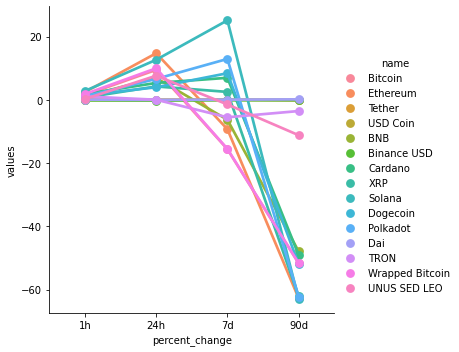

In [33]:
sns.catplot(x='percent_change', y='values', hue='name', data=df7, kind='point')

In [37]:
#query the dataset
df8 = df[['name','quote.USD.price','timestamp']]
df8 = df8.query("name == 'Bitcoin'")
df8

,name,quote.USD.price,timestamp
0,Bitcoin,20510.43320,2022-06-20 09:04:28.207920
0,Bitcoin,20575.92488,2022-06-20 09:23:07.525084
0,Bitcoin,20575.92488,2022-06-20 09:24:07.920792


C:\Anaconda\lib\site-packages\seaborn\_core.py:1057: FutureWarning: reindexing with a non-unique Index is deprecated and will raise in a future version.
  comp_col.loc[orig.index] = pd.to_numeric(axis.convert_units(orig))


ValueError: cannot reindex on an axis with duplicate labels

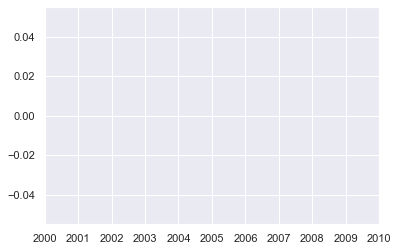

In [38]:
sns.set_theme(style="darkgrid")

sns.lineplot(x='timestamp', y='quote.USD.price', data = df8)